In [162]:
from for_importing import X_cleaned
from binning_to_import import y_bins

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [164]:

class DeepNN(nn.Module):
    def __init__(self, input_size):
        super(DeepNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

nfeatures = 8
model = DeepNN(nfeatures)

In [165]:
X=X_cleaned[['racepctblack', 'racePctWhite', 'pctWInvInc', 'pctWPubAsst',
       'PctPopUnderPov', 'TotalPctDiv', 'PctKids2Par', 'PctPersOwnOccup']].to_numpy()
y=y_bins['cluster'].astype(int).to_numpy()
xtr,xts,ytr,yts=train_test_split(X,y,test_size=0.2,random_state=22)

In [166]:
from torch.utils.data import DataLoader, TensorDataset


Xtr_torch =torch.tensor(xtr, dtype=torch.float32)
Xts_torch = torch.tensor(xts,dtype=torch.float32)
ytr_torch = torch.tensor(ytr,dtype=torch.int32)
yts_torch = torch.tensor(yts, dtype=torch.int32)

train_dataset = TensorDataset(Xtr_torch,ytr_torch)
test_dataset = TensorDataset(Xts_torch,yts_torch)

batch_size = 100
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)



In [167]:
import torch.optim as optim

pos_weight = torch.tensor([4.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(),lr=.001)

In [168]:
# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 100

for epoch in range(epochs):
    # Train over epoch
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        target = target.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == target).sum().item()

        total += target.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    loss_history.append(avg_loss)
    train_accuracy_history.append(train_accuracy)

    # Test over epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.float().unsqueeze(1)
            outputs = model(data)
            predicted = torch.argmax(outputs, dim=1)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == target).sum().item()
            total += target.size(0)

    test_accuracy = correct / total
    test_accuracy_history.append(test_accuracy)

    # Print accuracy
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, '
              f'Training Accuracy: {round(train_accuracy,2)}%, Test Accuracy: {round(test_accuracy*100,2)}%')


Epoch [10/100], Loss: 0.9416, Training Accuracy: 79.75%, Test Accuracy: 87.22%
Epoch [20/100], Loss: 0.9392, Training Accuracy: 79.78%, Test Accuracy: 88.47%
Epoch [30/100], Loss: 0.9329, Training Accuracy: 79.78%, Test Accuracy: 87.72%
Epoch [40/100], Loss: 0.9361, Training Accuracy: 79.76%, Test Accuracy: 86.47%
Epoch [50/100], Loss: 0.9264, Training Accuracy: 79.76%, Test Accuracy: 86.22%
Epoch [60/100], Loss: 0.9286, Training Accuracy: 79.77%, Test Accuracy: 83.21%
Epoch [70/100], Loss: 0.9273, Training Accuracy: 79.75%, Test Accuracy: 86.47%
Epoch [80/100], Loss: 0.9266, Training Accuracy: 79.77%, Test Accuracy: 86.97%
Epoch [90/100], Loss: 0.9205, Training Accuracy: 79.74%, Test Accuracy: 86.47%
Epoch [100/100], Loss: 0.9207, Training Accuracy: 79.76%, Test Accuracy: 86.97%


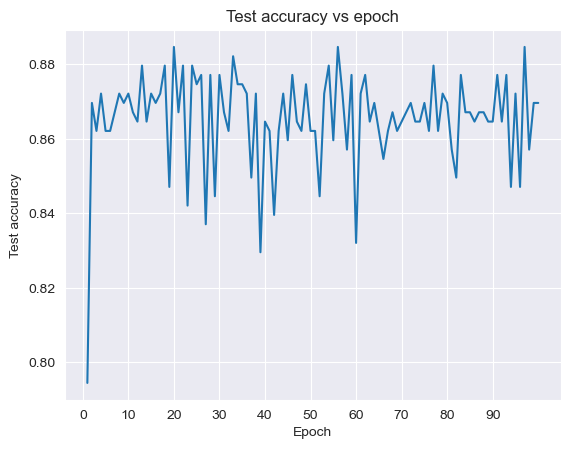

In [169]:

plt.plot(range(1,101),test_accuracy_history)
plt.title('Test accuracy vs epoch')
plt.xticks(range(0,100,10))
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.show()

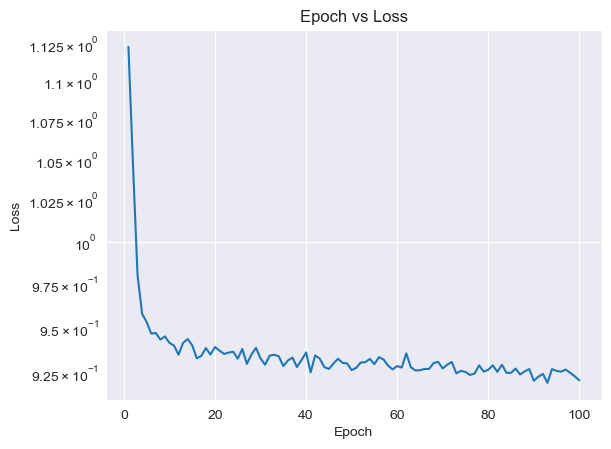

In [170]:
plt.semilogy(range(1,101),loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.show()

In [171]:
rates = [1e-4, 1e-3, 1e-2]
test_acc_lr = []
loss_hist_lr = []


for lr in rates:

    model = DeepNN(8)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)


    # Lists to store training and testing accuracy for each epoch
    train_accuracy_history = []
    test_accuracy_history = []
    loss_history = []

    # Number of epochs
    epochs = 20

    # Training loop
    for epoch in range(epochs):
      # Train over epoch
      model.train()
      total_loss = 0
      correct = 0
      total = 0

      for data, target in train_loader:
          target = target.float().unsqueeze(1)
          optimizer.zero_grad()
          outputs = model(data)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          predicted = torch.argmax(outputs, dim=1)
          predicted = (outputs >= 0.5).float()
          correct += (predicted == target).sum().item()

          total += target.size(0)

      avg_loss = total_loss / len(train_loader)
      train_accuracy = correct / total
      loss_history.append(avg_loss)
      train_accuracy_history.append(train_accuracy)

      # Test over epoch
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for data, target in test_loader:
              target = target.float().unsqueeze(1)
              outputs = model(data)
              predicted = torch.argmax(outputs, dim=1)
              predicted = (outputs >= 0.5).float()
              correct += (predicted == target).sum().item()
              total += target.size(0)

      test_accuracy = correct / total
      test_accuracy_history.append(test_accuracy)

    test_acc_lr.append(test_accuracy_history)
    loss_hist_lr.append(loss_history)


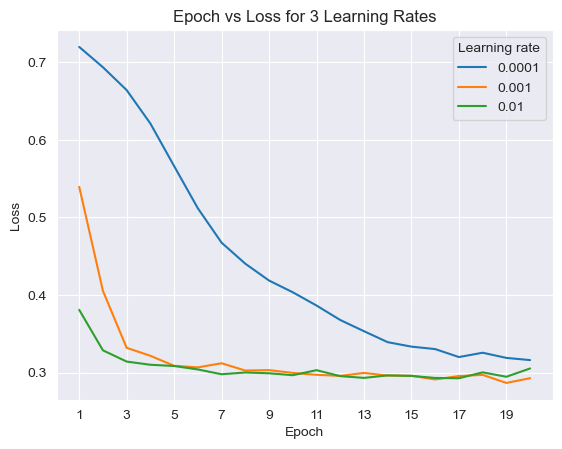

In [172]:

for lr in range(3):
  plt.plot(range(1,21),loss_hist_lr[lr],label=rates[lr])

plt.legend(title='Learning rate')
plt.xlabel('Epoch')
plt.xticks(range(1,21,2))
plt.ylabel('Loss')
plt.title('Epoch vs Loss for 3 Learning Rates')
plt.show()